In [1]:
import numpy as np
import pymc3 as pm
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import aesara.tensor as at
from aesara.tensor.random.op import RandomVariable

from scipy import stats as st

import aesara

%config InlineBackend.figure_format = "retina"
%matplotlib inline

You are running the v4 development version of PyMC3 which currently still lacks key features. You probably want to use the stable v3 instead which you can either install via conda or find on the v3 GitHub branch: https://github.com/pymc-devs/pymc3/tree/v3


## Sampling Procedure

### DP Prior

Atoms are denoted by $\theta_h$ whereas samples are denoted by $x_h$ (for $h = 1, \dots, K$).

\begin{align*}
    \theta_h &\stackrel{\text{i.i.d.}}{\sim} G_0\\
    v_h &\stackrel{\text{i.i.d.}}{\sim} \text{Beta}(1, \alpha)\\
    w_h &= v_h \prod_{\ell < h} (1 - v_h)\\
    x_h &\stackrel{\text{i.i.d.}}{\sim} \text{Categorical}(w_1, \dots, w_K)
\end{align*}

where $P(x = \theta_h) = w_h$.

### DP Posterior

Given data $\pmb{y} = (y_1, \dots, y_n)$:

\begin{align*}
    p_h &\stackrel{\text{i.i.d.}}{\sim} \text{Bern}\left(\frac{\alpha}{\alpha + n}\right)\\
    \theta_h | p_h = 1 &\sim G_0\\
    P(\theta_h = y_j | p_h = 0) &= \frac{1}{n} \qquad \forall \, j = 1, \dots, n\\
    v_h &\stackrel{\text{i.i.d.}}{\sim} \text{Beta}(1, \alpha)\\
    w_h &= v_h \prod_{\ell < h} (1 - v_\ell)\\
    P(x = \theta_h) &= w_h
\end{align*}

`rng = np.random.RandomState(seed=34)`, M = 1, K = 50 will yield negative probabilities

In [2]:
K = 50; N = 1000
M = 5; mu = 2.
rng = np.random.RandomState(seed=34)
y = rng.normal(loc=2., scale=2., size=[50,])

In [3]:
def generate_weights(M, rng, K):

    betas = rng.beta(1., M, size=(K-1,))
    
    sticks = np.append([[1]], np.cumprod(1 - betas[:-1]))

    product = betas * sticks
    
    return np.append(product, 1 - product.sum()) # shape = (K,)


def stick_glueing(weights):
    
    denominator = np.append([[1]], -weights[:-1])
    denominator = np.cumsum(denominator)
    
    return weights/denominator # shape = (K - 1,)


def create_dp_samples(M, rng, size):
    
    N, K = size
    
    samples = []
    empirical_weights = []
    
    global weights
    
    for _ in range(N):
        atoms = rng.normal(loc=mu, scale=2., size=(K,))
        weights = generate_weights(M, rng, K)
        
        sample = rng.choice(a=atoms, size=(K,), p=weights)
        
        unique_samples, counts = np.unique(sample, return_counts=True)

        samples.extend(list(unique_samples))
        
        """
        [:-1] because the last element is 1 by construction of weights
        """
        
        empirical_weights.extend(list(stick_glueing(counts/(K)))[:-1])
        
        assert counts.sum() == K
        
    return np.array(samples), np.array(empirical_weights)

In [4]:
# single run for testing

atoms = rng.normal(loc=0, scale=3., size=(K,))
weights = generate_weights(M, rng, K)
rng.choice(a=atoms, size=(K,), p=weights)

print(stick_glueing(weights))

del atoms, weights

[2.96757589e-03 1.51964649e-03 3.30340291e-02 3.31473290e-01
 1.22348495e-01 6.51054609e-01 2.23749013e-03 4.19746543e-02
 1.77699748e-01 4.30344187e-01 9.27542385e-03 1.97047706e-02
 2.69614546e-01 3.67060657e-01 2.22879552e-01 5.15104015e-01
 9.94445406e-02 1.06838193e-01 7.77376666e-04 9.71410737e-04
 2.40331512e-01 5.95222210e-02 1.30133717e-01 2.84008875e-01
 3.41350322e-01 3.69930889e-01 1.70601927e-01 9.60831381e-02
 1.31183722e-01 2.34878463e-01 7.77077415e-03 2.55351707e-02
 3.17828097e-01 5.78204894e-02 1.46084245e-01 4.92046829e-01
 2.42366444e-01 1.71150716e-01 1.35574278e-01 2.29544551e-01
 2.58684037e-01 4.96067745e-01 6.90854182e-02 4.03571963e-01
 2.23876254e-01 8.92239989e-02 1.92744317e-01 4.74958258e-02
 7.36751938e-02 1.00000000e+00]


In [5]:
atoms, recovered_betas = create_dp_samples(M, rng, size=[N, K])

with pm.Model(rng_seeder=rng) as model:
    α = pm.Uniform("α", 0., 10.)

    # K - 1 because the Kth weight is 1 - weights.sum()
    β = pm.Beta("β", 1., α, observed=recovered_betas)
    µ = pm.Normal("µ", mu=0., sigma=5.)

    G0 = pm.Normal("G0", mu=µ, sigma=3., observed=atoms)

    posterior = pm.sample(draws=2000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [α, µ]


Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 8 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


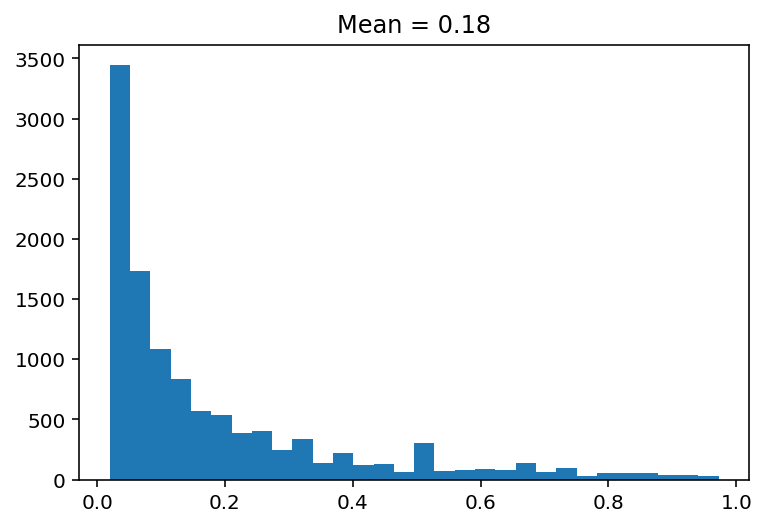

In [6]:
_ = plt.hist(recovered_betas, bins=30)
_ = plt.title(f"Mean = {recovered_betas.mean():.2f}")

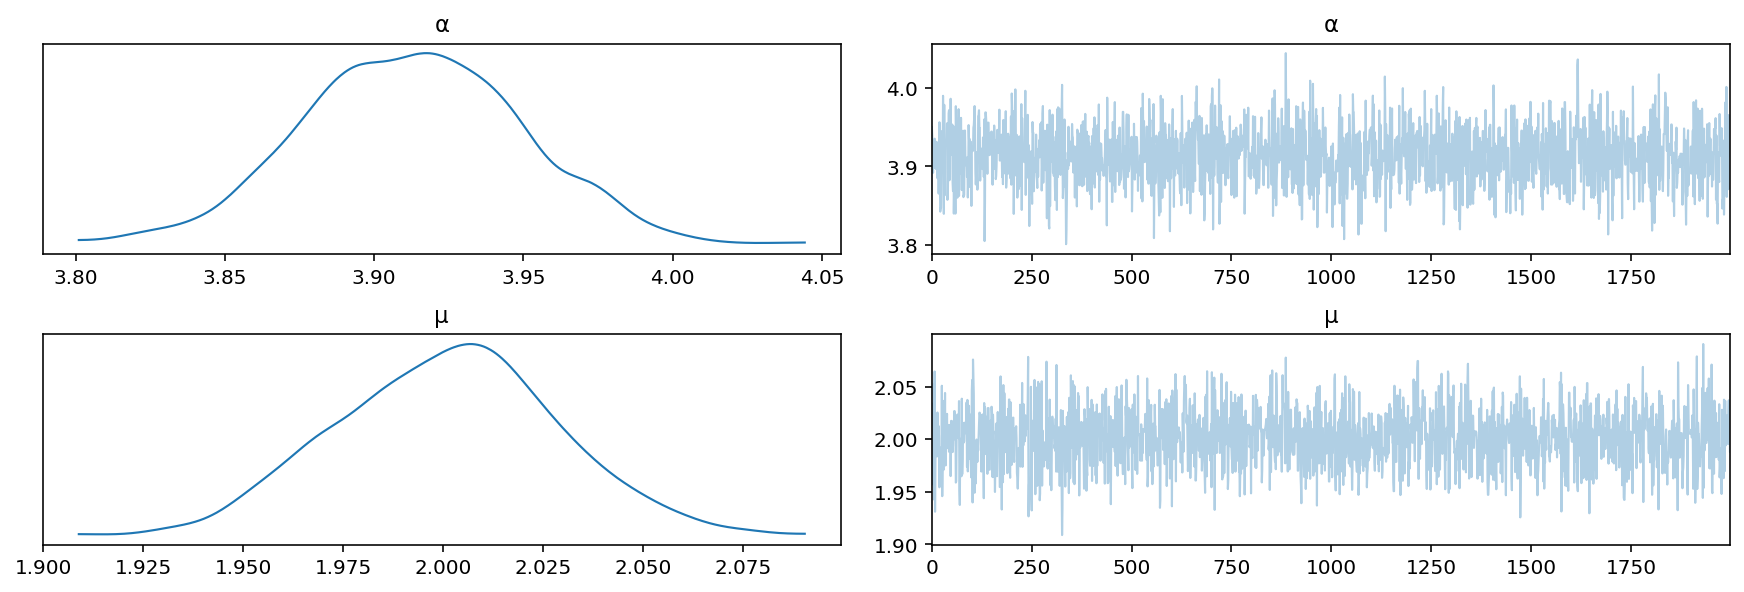

In [7]:
_ = pm.plot_trace(posterior)

In [8]:
posterior.to_dict()["posterior"]["α"].mean(), posterior.to_dict()["posterior"]["µ"].mean()

/Users/larryshamalama/anaconda3/envs/pymc3-dev-py38/lib/python3.8/site-packages/arviz/data/inference_data.py:436: UserWarning: The attributes are not same for all groups. Considering only the first group `attrs`
  warnings.warn(


(3.912939833623694, 2.001059355148315)

In [9]:
class DirichletProcess:
    """
    class to retrieve data-generating parameters (M and mu)
    
    posterior method not ready
    """
    def __init__(self, M, rng, size, observed=None):
        self.M = M
        self.rng = rng
        self.size = size
        
        self.N, self.K = size
        
        self.atoms, self.recovered_betas = create_dp_samples(self.M, self.rng, self.size)
    
        self.observed = observed
        self.n = len(observed)
        
    @property
    def recover_prior_params(self):
        
        with pm.Model(rng_seeder=self.rng) as model:
            α = pm.Uniform("α", 0., 10.)
            
            # K - 1 because the Kth weight is 1 - weights.sum()
            β = pm.Beta("β", 1., α, observed=self.recovered_betas)
            µ = pm.Normal("µ", mu=0., sigma=5.)
            
            G0 = pm.Normal("G0", mu=µ, sigma=3., observed=self.atoms)
            
            return pm.sample(draws=2000, chains=1)
        
    @property
    def posterior(self):
        
        if self.observed is None:
            raise ValueError("Forgot to provide some observations to condition on!")
        
        with pm.Model(rng_seeder=self.rng) as model:
            α = pm.Uniform("α", 0., 10.)
            
            β = pm.Beta("β", 1., α)
            µ = pm.Normal("µ", mu=0., sigma=5.)
            
            # latent mixture component for posterior
            idx = pm.Bernoulli("p", p=α/(α + self.n))
            G0 = pm.Normal("G0", mu=µ, sigma=3.)
            
            categorical_indicator = pm.Categorical("categorical", np.tile(1/self.n, self.n))
            
            dp_post_comps = [
                at.as_tensor_variable(self.observed)[categorical_indicator],
                G0,
            ]
            
            Gn = pm.Deterministic("Gn", dp_post_comps[idx])
            
            return pm.sample(draws=2000, chains=1)

In [10]:
dp = DirichletProcess(M, rng, size=[N, K], observed=y)
posterior = dp.posterior

TypeError: list indices must be integers or slices, not TensorVariable

In [ ]:
_ = pm.plot_trace(prior)

In [ ]:
prior.to_dict()["posterior"]["α"].mean()

In [11]:
with pm.Model() as model:

    idx = pm.Bernoulli("idx", 0.6)
    mu1 = pm.Normal(
        "mu",
        mu=0., 
        sigma=2.,
    )
    mu2 = pm.Normal(
        "mu2",
        mu=2.,
        sigma=2.
    )
    
    a = pm.Deterministic("a", [mu1, mu2][idx])
    
    trace = pm.sample(draws=1000, chains=1)

TypeError: list indices must be integers or slices, not TensorVariable

In [ ]:
trace.posterior.a